## Introduction

This notebook is designed to train PrePR-CT and reproduce the results using the McFarland dataset. Before running the notebook, please ensure you have set the correct paths for the input and output files:

- **Data Path**: The location of the dataset files.
- **Results Path**: The directory where the output results will be saved.
- **Models Path**: The directory to save model checkpoints.
- **parent_dir**: The location of the cell type graphs

```python
data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"
parent_dir = "Cell-Type-Specific-Graphs/graphs/"

In [1]:
import scanpy as sc 
import pandas as pd
import os
import sys
import numpy as np
import gzip
import matplotlib.pyplot as pl
from statistics import mode
from numpy.random import RandomState
from sklearn.metrics.pairwise import euclidean_distances
import re
import seaborn as sns
from scipy.io import mmread
import pickle
from scipy.sparse import csr_matrix
from sklearn import preprocessing
import pickle
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import *
import tqdm.notebook as tq
import shutil
import sys 
sys.path.insert(0, '../')
import utils
import optuna
from importlib import reload
reload(utils)
from utils import *
from IPython.display import clear_output as clr
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import model
from importlib import reload
reload(model)
from model import *
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"


2024-11-06 15:30:52.569172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-11-06 15:30:55.605435: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Import the Data

In [2]:
adata = sc.read(data_path+'McFarland.h5ad')
adata = adata[~adata.obs.condition.isin(['BRD3379','AZD5591'])].copy()
adata

AnnData object with n_obs × n_vars = 16208 × 5000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_type', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'condition', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label', 'SEACell'
    var: 'ensembl_id', 'ncounts', 'ncells', 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Embed the compound structures using ChemBERTa

In [3]:
chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

chemberta.eval()
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 600)
    embeddings_mean = torch.zeros(len(smiles_list), 600)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt",padding=padding,truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls.numpy(), embeddings_mean.numpy()

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from rdkit import Chem
# Define a list of drugs and their corresponding SMILES strings
drug_smiles = {
    'Trametinib' : 'CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=CC=C(I)C=C1F)C1=CC(NC(C)=O)=CC=C1',
    'Dabrafenib' : 'CC(C)(C)C1=NC(=C(S1)C1=NC(N)=NC=C1)C1=C(F)C(NS(=O)(=O)C2=C(F)C=CC=C2F)=CC=C1',
    'Gemcitabine' : 'NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F',
    'Navitoclax' : '[H][C@@](CCN1CCOCC1)(CSC1=CC=CC=C1)NC1=C(C=C(C=C1)S(=O)(=O)NC(=O)C1=CC=C(C=C1)N1CCN(CC2=C(CCC(C)(C)C2)C2=CC=C(Cl)C=C2)CC1)S(=O)(=O)C(F)(F)F',
    'Taselisib' :'CC(C)N1N=C(C)N=C1C1=CN2CCOC3=CC(=CC=C3C2=N1)C1=CN(N=C1)C(C)(C)C(N)=O',
    'Everolimus' : '[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C=C(C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(C)\[C@H](C[C@]3([H])CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCC[C@@]3([H])C(=O)O2)OC)CC[C@@H](OCCO)[C@@H](C1)OC',
    'Idasanutlin' : 'COC1=CC(=CC=C1NC(=O)[C@@H]1N[C@@H](CC(C)(C)C)[C@@](C#N)([C@H]1C1=CC=CC(Cl)=C1F)C1=CC=C(Cl)C=C1F)C(O)=O',
    'Afatinib': 'CN(C)C\C=C\C(=O)NC1=C(O[C@H]2CCOC2)C=C2N=CN=C(NC3=CC(Cl)=C(F)C=C3)C2=C1',
    'Bortezomib' : 'CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=CN=CC=N1)B(O)O',
    'JQ1' : 'CC1=C(C)C2=C(S1)N1C(C)=NN=C1[C@H](CC(=O)OC(C)(C)C)N=C2C1=CC=C(Cl)C=C1',
    'Prexasertib' : 'COC1=CC=CC(OCCCN)=C1C1=CC(NC2=CN=C(C=N2)C#N)=NN1',
    'control' : 'CS(C)=O'    
}

# Check if SMILES strings are canonical
canonical_smiles = {}
canonical_smiles_text = {}
for drug_name, smiles in drug_smiles.items():
    # Convert SMILES to RDKit molecule object
    print(smiles)
    mol = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    print(mol)
    canonical_smiles_text[drug_name] = mol
    canonical_smiles[drug_name] = featurize_ChemBERTa([mol])[1]

CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=CC=C(I)C=C1F)C1=CC(NC(C)=O)=CC=C1
CC(=O)Nc1cccc(-n2c(=O)n(C3CC3)c(=O)c3c(Nc4ccc(I)cc4F)n(C)c(=O)c(C)c32)c1


100%|██████████| 1/1 [00:00<00:00, 116.45it/s]


CC(C)(C)C1=NC(=C(S1)C1=NC(N)=NC=C1)C1=C(F)C(NS(=O)(=O)C2=C(F)C=CC=C2F)=CC=C1
CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1


100%|██████████| 1/1 [00:00<00:00, 143.20it/s]


NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F
Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)C2(F)F)c(=O)n1


100%|██████████| 1/1 [00:00<00:00, 218.51it/s]


[H][C@@](CCN1CCOCC1)(CSC1=CC=CC=C1)NC1=C(C=C(C=C1)S(=O)(=O)NC(=O)C1=CC=C(C=C1)N1CCN(CC2=C(CCC(C)(C)C2)C2=CC=C(Cl)C=C2)CC1)S(=O)(=O)C(F)(F)F
CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N[C@H](CCN5CCOCC5)CSc5ccccc5)c(S(=O)(=O)C(F)(F)F)c4)cc3)CC2)C1


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


CC(C)N1N=C(C)N=C1C1=CN2CCOC3=CC(=CC=C3C2=N1)C1=CN(N=C1)C(C)(C)C(N)=O
Cc1nc(-c2cn3c(n2)-c2ccc(-c4cnn(C(C)(C)C(N)=O)c4)cc2OCC3)n(C(C)C)n1


100%|██████████| 1/1 [00:00<00:00, 171.44it/s]


[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C=C(C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(C)\[C@H](C[C@]3([H])CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCC[C@@]3([H])C(=O)O2)OC)CC[C@@H](OCCO)[C@@H](C1)OC
CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H]([C@H](C)C[C@@H]2CC[C@@H](OCCO)[C@H](OC)C2)CC(=O)[C@H](C)/C=C(\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)/C=C/C=C/C=C/1C


100%|██████████| 1/1 [00:00<00:00, 115.24it/s]


COC1=CC(=CC=C1NC(=O)[C@@H]1N[C@@H](CC(C)(C)C)[C@@](C#N)([C@H]1C1=CC=CC(Cl)=C1F)C1=CC=C(Cl)C=C1F)C(O)=O
COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C)C)[C@](C#N)(c2ccc(Cl)cc2F)[C@H]1c1cccc(Cl)c1F


100%|██████████| 1/1 [00:00<00:00, 163.28it/s]


CN(C)C\C=C\C(=O)NC1=C(O[C@H]2CCOC2)C=C2N=CN=C(NC3=CC(Cl)=C(F)C=C3)C2=C1
CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]1CCOC1


100%|██████████| 1/1 [00:00<00:00, 183.60it/s]


CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=CN=CC=N1)B(O)O
CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cnccn1)B(O)O


100%|██████████| 1/1 [00:00<00:00, 200.99it/s]


CC1=C(C)C2=C(S1)N1C(C)=NN=C1[C@H](CC(=O)OC(C)(C)C)N=C2C1=CC=C(Cl)C=C1
Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(C)n1-2


100%|██████████| 1/1 [00:00<00:00, 189.40it/s]


COC1=CC=CC(OCCCN)=C1C1=CC(NC2=CN=C(C=N2)C#N)=NN1
COc1cccc(OCCCN)c1-c1cc(Nc2cnc(C#N)cn2)n[nH]1


100%|██████████| 1/1 [00:00<00:00, 206.57it/s]


CS(C)=O
CS(C)=O


100%|██████████| 1/1 [00:00<00:00, 247.12it/s]


## Import the Cell Type Graphs in a Dictionary Form

In [5]:
cell_type_network = {}
# Leaf directory 
directory = "McFarland"
# Parent Directories 
parent_dir = "Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in adata.obs.cell_type.unique():
    print(cell_type)
    cell_type_network[cell_type] = torch.load(os.path.join(path,cell_type+'_coexpr_graph.pkl'))
    if cell_type_network[cell_type].num_nodes >= max_nodes:
        max_nodes = cell_type_network[cell_type].num_nodes
print(max_nodes)
cell_type_network    

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/McFarland
File exists!
COLO680N
TEN
RCC10RGB
LNCAPCLONEFGC
BICR31
4510


{'COLO680N': Data(x=[4401, 11], edge_index=[2, 245306], edge_attr=[245306], pos=[4401]),
 'TEN': Data(x=[3290, 9], edge_index=[2, 245354], edge_attr=[245354], pos=[3290]),
 'RCC10RGB': Data(x=[4510, 6], edge_index=[2, 245466], edge_attr=[245466], pos=[4510]),
 'LNCAPCLONEFGC': Data(x=[2916, 15], edge_index=[2, 245160], edge_attr=[245160], pos=[2916]),
 'BICR31': Data(x=[4387, 17], edge_index=[2, 245302], edge_attr=[245302], pos=[4387])}

## Identify the testing drugs based on the E-distance from the control

In [6]:
testing_cell = 'LNCAPCLONEFGC'
from scperturb import *
estats = edist(adata[adata.obs.cell_type == testing_cell].copy(), obs_key='condition', obsm_key='X_pca', dist='sqeuclidean')
# testing_drug = estats.idxmax(axis = 1).loc['control']
# print(testing_drug)
# estats.loc['control']
# estats
testing_drugs = ['Bortezomib', 'JQ1', 'Gemcitabine']


100%|██████████| 12/12 [00:00<00:00, 86.09it/s]


## Compute DEGs per cell type and drug

In [7]:
adata.uns['gene_network'] = {}
adata.uns['rank_genes_groups_cov_DEGs'] = {}
for cell_type in adata.obs.cov_drug.unique():
    if cell_type.split('_')[1] != 'control':
        adata_cov = adata[(adata.obs.cov_drug == cell_type) | (adata.obs.cov_drug == cell_type.split('_')[0]+'_control'), 
        cell_type_network[cell_type.split('_')[0]].pos.tolist()].copy()
        adata_cov.uns['log1p']['base'] = None
        sc.tl.rank_genes_groups(adata_cov, groupby = 'cov_drug',rankby_abs = True,
                                        reference = cell_type.split('_')[0]+'_control',n_genes = len(adata_cov.var))
        dedf = sc.get.rank_genes_groups_df(adata_cov, group=cell_type)
        dedf = dedf.loc[dedf['pvals_adj'] < 0.05].copy()
        DEGs_name = rank_genes(dedf)
        df = adata_cov.var.reset_index()
        adata.uns['gene_network'][cell_type] = cell_type_network[cell_type.split('_')[0]].pos.tolist()
        adata.uns['rank_genes_groups_cov_DEGs'][cell_type] = DEGs_name
        # pd.DataFrame(DEGs_name).to_csv(save_path_results+"McFarland_"+cell_type+"_DEGs_name.csv")
        # pd.DataFrame(adata_cov.var.index.values).to_csv(save_path_results+"McFarland_"+cell_type+"_all_genes.csv")

## Split the data 

In [8]:
adata.obs["dose_value"] = 1.0
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].max()+1
adata.obs['split'] = 'train'
adata.obs.loc[(adata.obs.cell_type == testing_cell) & (adata.obs["condition"].isin(testing_drugs)), 'split'] = 'ood'
valid_idx = sc.pp.subsample(adata[(adata.obs['split'] != "ood") & (adata.obs['condition'] != "control")], 0.20, copy=True, random_state = 42).obs.index
adata.obs["split"].loc[valid_idx] = "valid"
display(adata.obs.split.value_counts())

/tmp/ipykernel_759894/2065125377.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["split"].loc[valid_idx] = "valid"


split
train    13229
valid     2577
ood        402
Name: count, dtype: int64

## Match Control to Treatment Cells

In [9]:
stim_data = adata[adata.obs.condition != 'control'].copy()
stim_data.layers['ctrl_x'] = stim_data.X.A
#stim_data = sc.pp.subsample(stim_data, fraction = 0.80, copy = True)
ctrl_data = adata[adata.obs.condition == 'control'].copy()
# ctrl_data_tensor = {}
## assign one ctrl cell to each perturbed cell within the same cell type
for cell_type in adata.obs.cell_type.unique():
    genes = cell_type_network[cell_type].pos.tolist()
    cell_type_network[cell_type].x = torch.mean(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    std = torch.var(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    cell_type_network[cell_type].x = torch.cat([cell_type_network[cell_type].x.unsqueeze(1), std.unsqueeze(1)], dim = 1)    


for cov_drug in stim_data.obs.cov_drug.unique():
    cell_type = cov_drug.split('_')[0]
    ad_ctrl = ctrl_data[ctrl_data.obs.cell_type == cell_type].copy()
    ad_stim = stim_data[stim_data.obs.cov_drug == cov_drug].copy()
    num_samples = len(ad_stim)
    sele_samples = balance_subsample(np.array(ad_ctrl.obs.index.values.tolist()), np.array(ad_ctrl.obs.SEACell.values.tolist()), num_samples)
    stim_data[ ad_stim.obs.index.values,: ].layers['ctrl_x'] = ad_ctrl[sele_samples, :].copy().X.A

## Save the data in a form of PyG Data objects to train GNN

In [10]:
# cells_train = create_cells(stim_data[stim_data.obs.split == 'train'].copy(), cell_type_network, canonical_smiles)
# cells_valid = create_cells(stim_data[stim_data.obs.split == 'valid'].copy(), cell_type_network, canonical_smiles)
# cells_ood = create_cells(stim_data[stim_data.obs.split == 'ood'].copy(), cell_type_network, canonical_smiles)

# with open(data_path+'cells_train_McFarland.pkl', 'wb') as f:
#     pickle.dump(cells_train, f)
# with open(data_path+'cells_valid_McFarland.pkl', 'wb') as f:
#     pickle.dump(cells_valid, f)
# with open(data_path+'cells_ood_McFarland.pkl', 'wb') as f:
#     pickle.dump(cells_ood, f)

In [11]:
with open(data_path+'cells_train_McFarland.pkl', 'rb') as pickle_file:
    cells_train = pickle.load(pickle_file)

with open(data_path+'cells_valid_McFarland.pkl', 'rb') as pickle_file:
    cells_valid = pickle.load(pickle_file)

with open(data_path+'cells_ood_McFarland.pkl', 'rb') as pickle_file:
    cells_ood = pickle.load(pickle_file)
    
print(len(cells_train), len(cells_valid), len(cells_ood))
(10312+2577) % 256

10312 2577 402


89

## Train & test the model

  0%|          | 0/3 [00:00<?, ?it/s]

Gemcitabine


  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9671078184995068
R2 top 50 DEGs:  0.9863621800578424
R2 all genes:  0.9800754884334931
R2 top 100 DEGs:  0.9871167750753911
2916


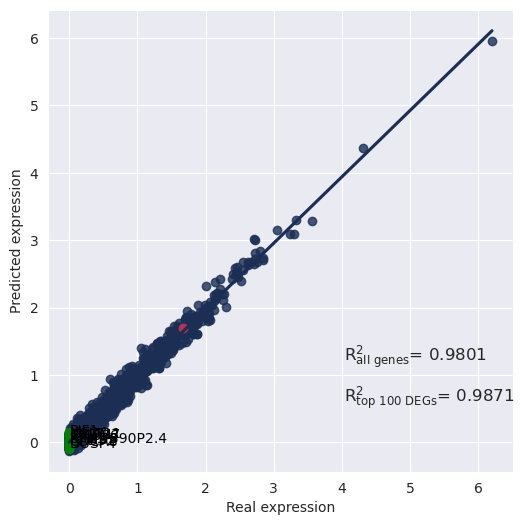

<Figure size 640x480 with 0 Axes>

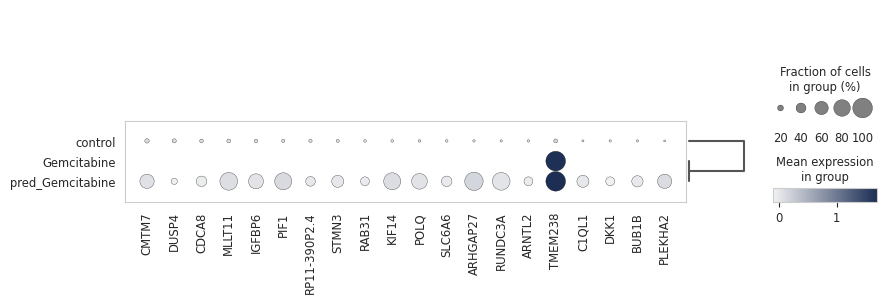

  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  -1.6746044741363644
R2 top 50 DEGs:  0.33586694987152543
R2 all genes:  0.7046281176416376
R2 top 100 DEGs:  0.725625537039443
2916


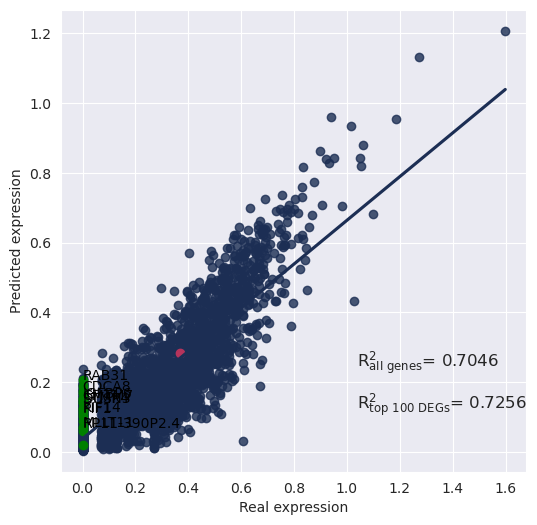

<Figure size 640x480 with 0 Axes>

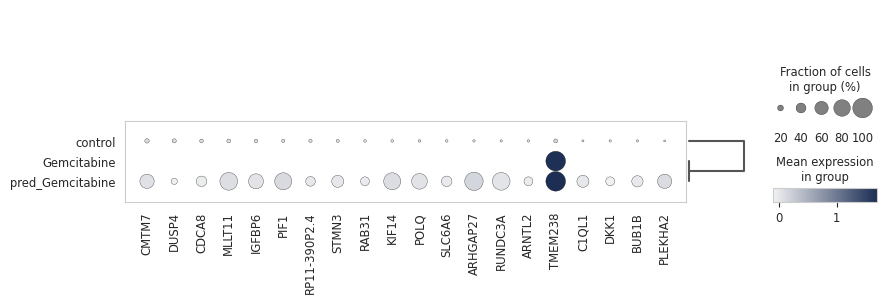

Bortezomib


  0%|          | 0/2 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9673705685024082
R2 top 50 DEGs:  0.9742354551264304
R2 all genes:  0.9556998079722394
R2 top 100 DEGs:  0.9632856036856605
2916


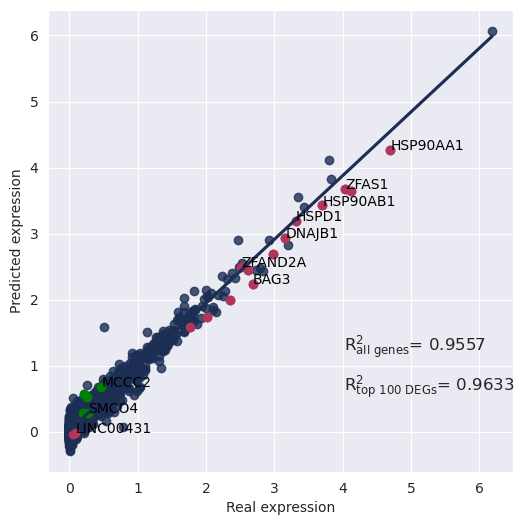

<Figure size 640x480 with 0 Axes>

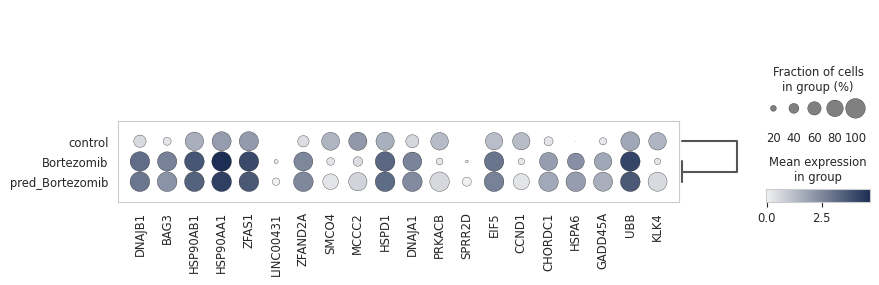

  0%|          | 0/2 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.5449683198948563
R2 top 50 DEGs:  0.7761901108496331
R2 all genes:  0.7478519016268869
R2 top 100 DEGs:  0.738309159497935
2916


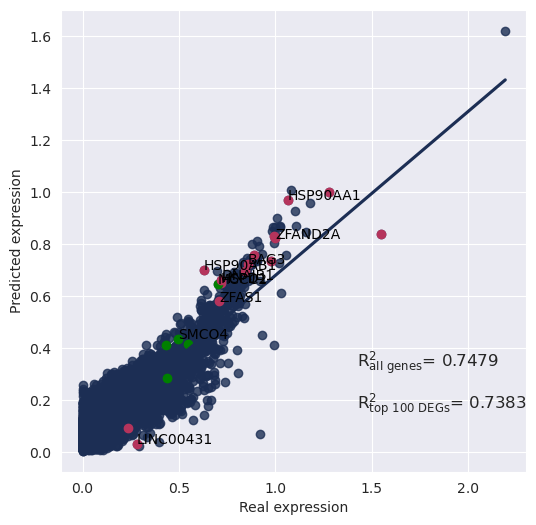

<Figure size 640x480 with 0 Axes>

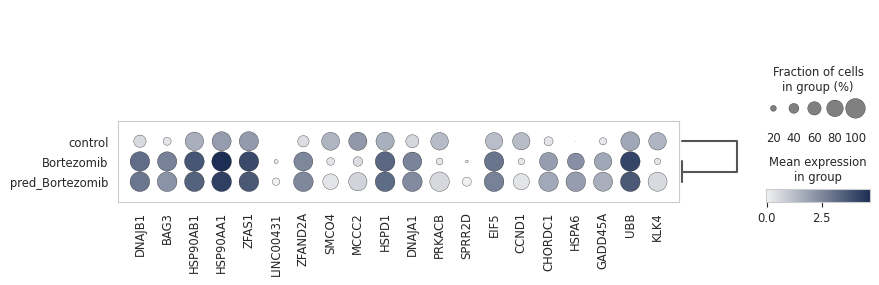

JQ1


  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  -70.58006744621731
R2 top 50 DEGs:  0.8240845362519147
R2 all genes:  0.9598989812181291
R2 top 100 DEGs:  0.9376804320451502
2916


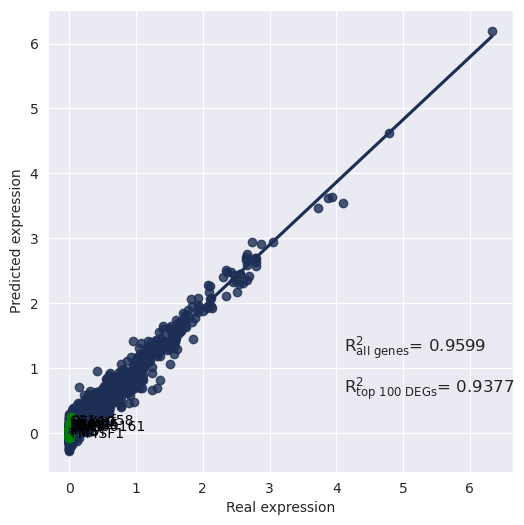

<Figure size 640x480 with 0 Axes>

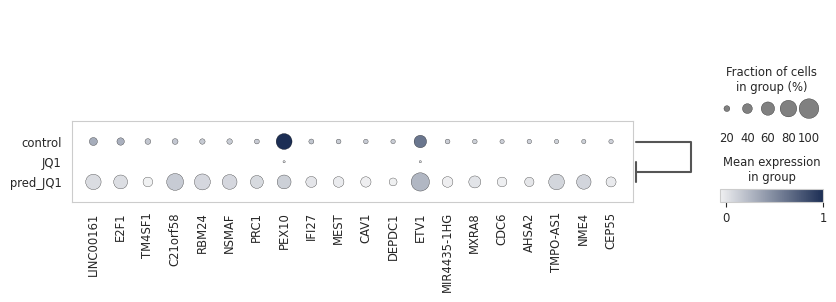

  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  -21.97492237837237
R2 top 50 DEGs:  -0.14890393122937495
R2 all genes:  0.6966113271092659
R2 top 100 DEGs:  0.5054928468618838
2916


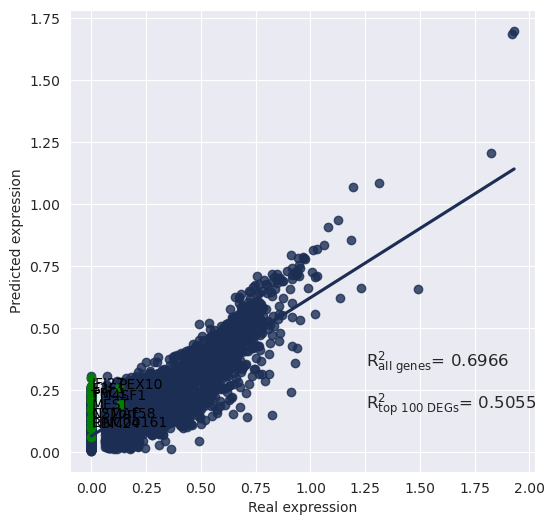

<Figure size 640x480 with 0 Axes>

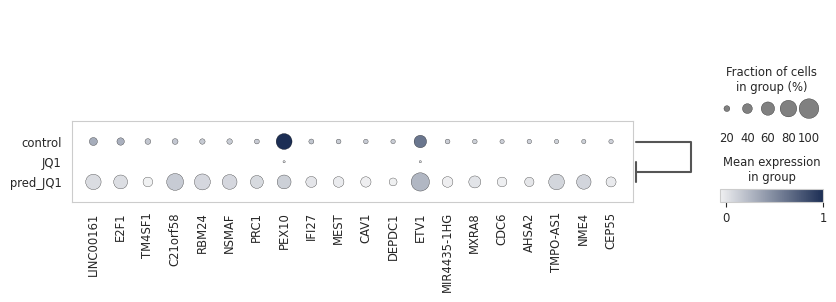

r2_all_avg 0.9652247592079538 r2_degs_avg 0.9626942702687339 r2_all_std 0.7163637821259301 r2_degs_std 0.656475847799754


In [22]:
from importlib import reload
import utils
reload(utils)
from utils import *
import model
from importlib import reload
reload(model)
from model import *
import optuna

params = {'hidden_channels': 128, 'weight_decay': 1e-05, 'in_head': 1, 'learning_rate': -3, 'num_epochs': 200, 'batch_size': 256}
train_dataloader = DataLoader(cells_train+cells_valid, batch_size=params['batch_size'], shuffle=True)
model = GNN(total_genes  = len(adata.var), num_perts = num_perts, act_fct = 'Sigmoid',
            hidden_channels = params['hidden_channels'], in_head = params['in_head']).to(device)

# model = train(model = model, num_epochs = params['num_epochs'], lr = 10**params['learning_rate'],
#             weight_decay = params['weight_decay'],
#             cell_type_network = cell_type_network, train_loader = train_dataloader)
# torch.save(model.state_dict(), save_path_models+"McFarland_model.pt")

model.load_state_dict(torch.load(save_path_models+"McFarland_model.pt"))
r2_all_avg = []
r2_degs_avg = []
r2_all_std = []
r2_degs_std = []
ood_loader_all = DataLoader(cells_ood, batch_size=len(cells_ood), shuffle=False)
ood_cells = np.array(next(iter(ood_loader_all)).cell_type)
cov_drugs = np.array(next(iter(ood_loader_all)).cov_drug)
pred_adata = []
DEGs_name_drug = {}
for cov_drug in tq.tqdm(set(cov_drugs)):
    testing_drug = cov_drug.split('_')[1]
    ood_cell = cov_drug.split('_')[0]
    index_cell_type = np.where(cov_drugs == cov_drug)[0]
    data = [cells_ood[i] for i in index_cell_type]
    ood_loader_cell_type = DataLoader(data, batch_size=params['batch_size'], shuffle=False)
    if testing_drug != 'control':
        print(testing_drug)
        r2_all, r2_DEGs, DEGs_name, dot_adata =  Inference(cell_type_network, model, 
                   save_path_results+"McFarland_mean_"+testing_drug, ood_loader_cell_type, 
                   ood_cell, adata, testing_drug = testing_drug, 
                   degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cell+'_'+testing_drug], mean_or_std = True, plot = True)
        r2_all_avg.append(r2_all)
        r2_degs_avg.append(r2_DEGs)
        #---------------------------------------------------------------------------------------------------------
        r2_all, r2_DEGs, DEGs_name, dot_adata = Inference(cell_type_network, model, 
                   save_path_results+"McFarland_std_"+testing_drug, ood_loader_cell_type, 
                   ood_cell, adata, testing_drug = testing_drug, 
                   degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cell+'_'+testing_drug], mean_or_std = False, plot = True)
        r2_all_std.append(r2_all)
        r2_degs_std.append(r2_DEGs)
        pred_adata.append(dot_adata)
        DEGs_name_drug[testing_drug] = DEGs_name
pred_adata.append(adata[adata.obs.cov_drug == testing_cell+'_control', cell_type_network[testing_cell].pos.tolist()].copy())

print( 'r2_all_avg', np.mean(r2_all_avg),
        'r2_degs_avg', np.mean(r2_degs_avg),
        'r2_all_std', np.mean(r2_all_std),
        'r2_degs_std', np.mean(r2_degs_std) )

## Visualize the UMAP of Observed and Predicted Expression

AnnData object with n_obs × n_vars = 1392 × 2916
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_type', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'condition', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label', 'SEACell', 'split'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

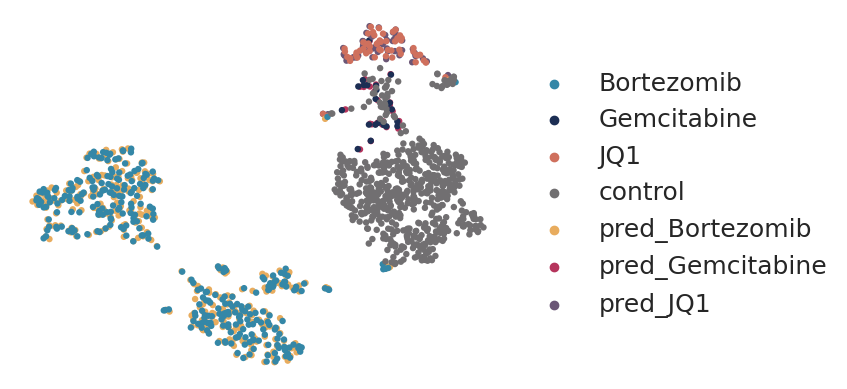

In [22]:
pred_adata_all = sc.concat(pred_adata, join='outer')
display(pred_adata_all)
pred_adata_all.obs.rename(columns={'condition': 'Treatment'}, inplace=True) 

sc.pp.neighbors(pred_adata_all)
sc.tl.umap(pred_adata_all) 
fig, ax = plt.subplots()
custom_colors = {'control': '#716F71', 'Gemcitabine': '#1C2E54', 'pred_Gemcitabine':'#B5345C',
                 'pred_Bortezomib': '#E8AC5E', 'Bortezomib': '#3487A7', 'pred_JQ1': '#6B5676', 'JQ1': '#CF705D'}
sc.pl.umap(pred_adata_all, color='Treatment',  ax=ax, show=False, palette=custom_colors, frameon=False, legend_fontsize=18)
# Remove the box (spines) around the plot
ax.set_title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(save_path_results+"UMAP_Pred_McFarland.pdf", bbox_inches='tight')
plt.show()